## Model with Visual Attention

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
annotation_file = r'/content/gdrive/MyDrive/DL/captions_train2014.json'
dataset_path="/content/gdrive/MyDrive/DL/TrainImages40k/"

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
import matplotlib.pyplot as plt
from keras.backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import json
from glob import glob
from PIL import Image
import pickle
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
annotation_file = r'/content/gdrive/MyDrive/DL/captions_train2014.json'

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
jpgs = os.listdir(dataset_path)
len(jpgs)

In [ ]:
from tqdm import tqdm
image_path_to_caption = collections.defaultdict(list)
filename=[]
caption_list=[]
for val in tqdm(annotations['annotations']):
    caption = val['caption']
    image_name = 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    if image_name in jpgs:
        filename.append(image_name)
        caption_list.append(caption)

100%|██████████| 414113/414113 [01:17<00:00, 5361.67it/s]


In [ ]:
import pandas as pd
dict1 = {'filename': filename, 'caption': caption_list}     
df = pd.DataFrame(dict1)
df.to_csv('/content/gdrive/MyDrive/DL/train_dataset.csv',index=False)

In [ ]:
data =pd.read_csv('/content/gdrive/MyDrive/DL/train_dataset.csv')

In [ ]:
data.head()

,filename,caption
0,COCO_train2014_000000032275.jpg,The vanity contains two sinks with a towel for...
1,COCO_train2014_000000025470.jpg,"A kitchen with brown cabinets, tile backsplash..."
2,COCO_train2014_000000018691.jpg,A few people sit on a dim transportation system.
3,COCO_train2014_000000028231.jpg,A black car is near someone riding a bike.
4,COCO_train2014_000000031813.jpg,A surfer riding his bike to the beach.


In [ ]:
data.shape

(52130, 2)

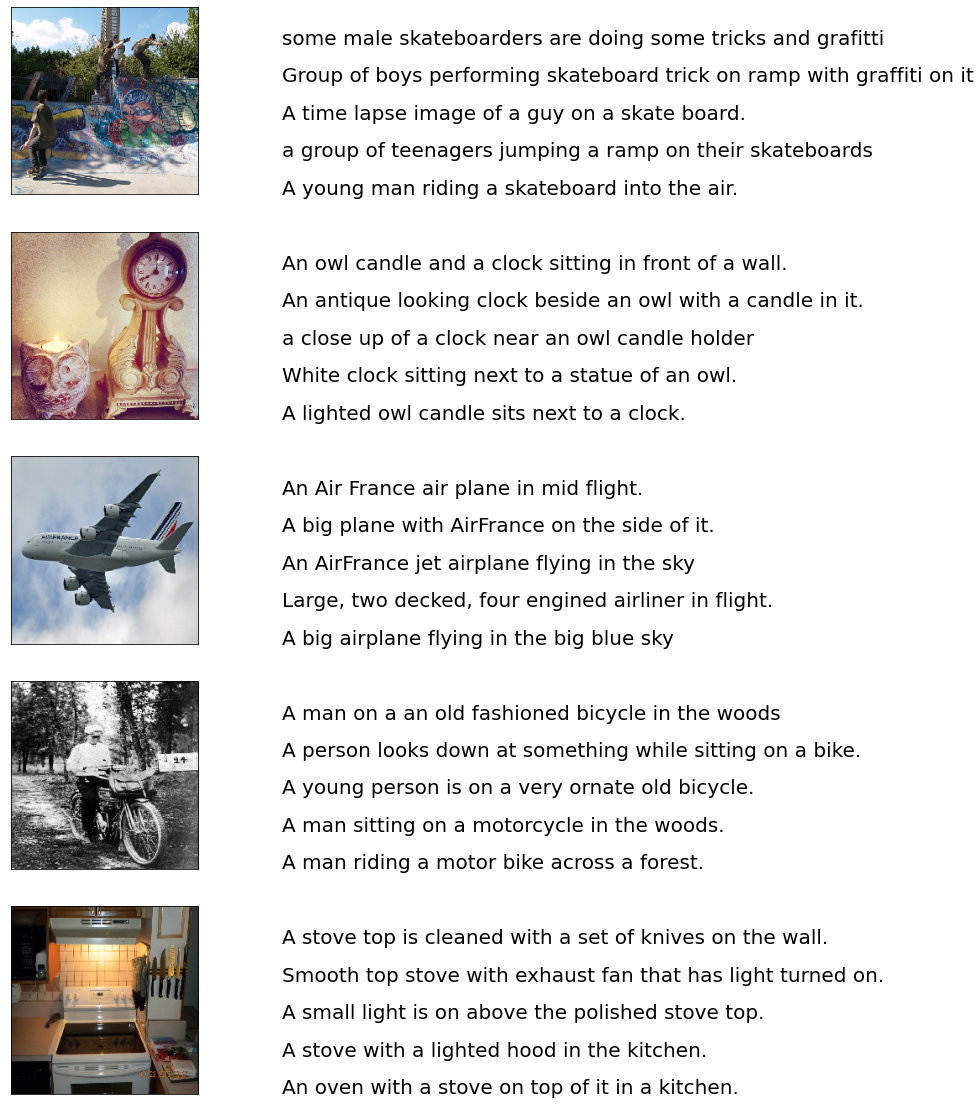

In [ ]:
def print_images(number_images,number_pixel):
  img_size = (number_pixel,number_pixel,3)
  unique_names = np.unique(data.filename.values)
  subplot_index = 1
  fig = plt.figure(figsize=(10,20))
  for file_name in unique_names[0:number_images]:
      filename = dataset_path + '/' + file_name
      captions = list(data["caption"].loc[data["filename"]==file_name].values)
      load_images = load_img(filename, target_size=img_size)
      
      ax = fig.add_subplot(number_images,2,subplot_index,xticks=[],yticks=[])
      ax.imshow(load_images)
      subplot_index += 1
      
      ax = fig.add_subplot(number_images,2,subplot_index)
      plt.axis('off')
      ax.plot()
      ax.set_xlim(0,1)
      ax.set_ylim(0,len(captions))
      for i, caption in enumerate(captions):
          ax.text(0,i,caption,fontsize=20)
      subplot_index += 1
  plt.show()

In [ ]:
print_images(8,224)

In [ ]:
def caption_preprocessing(data):
  captions=[]
  for value  in data["caption"].astype(str):
    captions.append('<start> ' + value+ ' <end>')
  return captions

['<start> The vanity contains two sinks with a towel for each. <end>',
 '<start> A kitchen with brown cabinets, tile backsplash, and grey counters. <end>',
 '<start> A few people sit on a dim transportation system.  <end>',
 '<start> A black car is near someone riding a bike. <end>',
 '<start> A surfer riding his bike to the beach. <end>',
 '<start> Clean bathroom that is brightly colored and has a window <end>',
 '<start> A person on a bicycle is riding in front of a car.   <end>',
 '<start> A black cat making an angry face while sitting on the bathroom floor  <end>',
 '<start> A bathroom with a TV near the mirror <end>',
 '<start> A bathroom in white has a cupboard above the sink. <end>']

In [ ]:
processed_captions =caption_preprocessing(data)
processed_captions[:5]

In [ ]:
def img_processing(data):
  name_vect = []
  for img_name in data["filename"]:
    name_vect.append(dataset_path + img_name)
  return name_vect

['/content/gdrive/MyDrive/DL/TrainImages40k/COCO_train2014_000000032275.jpg',
 '/content/gdrive/MyDrive/DL/TrainImages40k/COCO_train2014_000000025470.jpg',
 '/content/gdrive/MyDrive/DL/TrainImages40k/COCO_train2014_000000018691.jpg',
 '/content/gdrive/MyDrive/DL/TrainImages40k/COCO_train2014_000000028231.jpg',
 '/content/gdrive/MyDrive/DL/TrainImages40k/COCO_train2014_000000031813.jpg',
 '/content/gdrive/MyDrive/DL/TrainImages40k/COCO_train2014_000000044816.jpg',
 '/content/gdrive/MyDrive/DL/TrainImages40k/COCO_train2014_000000028231.jpg',
 '/content/gdrive/MyDrive/DL/TrainImages40k/COCO_train2014_000000072704.jpg',
 '/content/gdrive/MyDrive/DL/TrainImages40k/COCO_train2014_000000028149.jpg',
 '/content/gdrive/MyDrive/DL/TrainImages40k/COCO_train2014_000000056972.jpg']

In [ ]:
img_vector = img_processing(data)
img_vector[:5]

In [ ]:
train_cap_data, image_vector_name = shuffle(processed_captions,img_vector,random_state=1)

In [ ]:
def load_image(path):
    size_image=224
    n_channels=3
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=n_channels)
    image = tf.image.resize(image, (size_image, size_image))
    image = preprocess_input(image)
    return image, path

In [ ]:
cnn_model = tf.keras.applications.VGG16(include_top=False,weights='imagenet')
input_model = cnn_model.input
hidden_layer_model = cnn_model.layers[-1].output
cnn_model_feature = tf.keras.Model(input_model, hidden_layer_model)
cnn_model_feature.summary()

In [ ]:
def create_batch(batch_size,img_vector,load_image):
  train_enc = sorted(set(img_vector))
  img_dataset = tf.data.Dataset.from_tensor_slices(train_enc)
  img_dataset = img_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)
  return img_dataset

In [ ]:
batch_img_data=create_batch(64,image_vector_name,load_image)
print(f"Let's check the batch_img_data --> {batch_img_data}")

In [ ]:
def feature_extract(batch_img_data):
  for img, path in tqdm(batch_img_data):
    batch_features = cnn_model_feature(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

    for bfeat, pth in zip(batch_features, path):
      path_of_feature = pth.numpy().decode("utf-8")
      np.save(path_of_feature, bfeat.numpy())
  print(batch_features.numpy().shape)

100%|██████████| 163/163 [18:43<00:00,  6.90s/it]


In [ ]:
feature_extract(batch_img_data)

In [ ]:
def find_max(train_text_sequences):
    return max(len(t) for t in train_text_sequences)

In [ ]:
top_k = 30000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_cap_data)
train_text_sequences = tokenizer.texts_to_sequences(train_cap_data)


tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_text_sequences = tokenizer.texts_to_sequences(train_cap_data)

caption_vector = tf.keras.preprocessing.sequence.pad_sequences(train_text_sequences, padding='post')


print(caption_vector.shape)

(50000, 51)


In [ ]:
max_length = find_max(train_text_sequences)

train_images, val_images, train_captions, val_captions = train_test_split(image_vector_name,caption_vector,test_size=0.3,random_state=10)

In [ ]:
len(train_images), len(train_captions), len(val_images), len(val_captions)

(40000, 40000, 10000, 10000)

In [ ]:
#Configurations
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
rnn_units = 512
vocabulary_size = len(tokenizer.word_index) + 1
steps = len(train_images) // BATCH_SIZE
features_shape = 512
attention_shape = 49

In [ ]:
def load_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_captions))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          load_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, rnn_units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(rnn_units)
    self.W2 = tf.keras.layers.Dense(rnn_units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):

    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    aw = tf.nn.softmax(self.V(score), axis=1)

    cv = aw * features
    cv = tf.reduce_sum(cv, axis=1)

    return cv, aw

In [ ]:
class Encoder_CNN(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(Encoder_CNN, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class Decoder_RNN(tf.keras.Model):
  def __init__(self, embedding_dim, rnn_units, vocabulary_size):
    super(Decoder_RNN, self).__init__()
    self.rnn_units = rnn_units

    self.embedding = tf.keras.layers.Embedding(vocabulary_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.hidden_1 = tf.keras.layers.Dense(self.rnn_units)
    self.hidden_2 = tf.keras.layers.Dense(vocabulary_size)

    self.attention = BahdanauAttention(self.rnn_units)

  def call(self, x, features, hidden):
    cv, aw = self.attention(features, hidden)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(cv, 1), x], axis=-1)

    output, state = self.gru(x)
    x = self.hidden_1(output)

    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.hidden_2(x)

    return x, state, aw

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.rnn_units))

In [ ]:
encoder_network = Encoder_CNN(embedding_dim)
decoder_network = Decoder_RNN(embedding_dim, rnn_units, vocabulary_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_model = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_calc = loss_model(real, pred)

  mask = tf.cast(mask, dtype=loss_calc.dtype)
  loss_calc *= mask

  return tf.reduce_mean(loss_calc)

In [ ]:
checkpoint_path_ckpt = "./checkpoint_final/train"
ckpt = tf.train.Checkpoint(encoder=encoder_network,decoder=decoder_network,optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = decoder_network.reset_state(batch_size=target.shape[0])

  decoder_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder_network(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder_network(decoder_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          decoder_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder_network.trainable_variables + decoder_network.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 200 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    loss_plot.append(total_loss / steps)

    if epoch % 10 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,total_loss/steps))

Epoch 1 Batch 0 Loss 2.0947
Epoch 1 Batch 100 Loss 1.1591
Epoch 1 Batch 200 Loss 0.9004
Epoch 1 Batch 300 Loss 0.8974
Epoch 1 Batch 400 Loss 0.8999
Epoch 1 Batch 500 Loss 0.8478
Epoch 1 Batch 600 Loss 0.8365
Epoch 1 Loss 0.966174
Time taken for 1 epoch 176.68521332740784 sec

Epoch 2 Batch 0 Loss 0.7552
Epoch 2 Batch 100 Loss 0.8012
Epoch 2 Batch 200 Loss 0.7516
Epoch 2 Batch 300 Loss 0.7594
Epoch 2 Batch 400 Loss 0.7768
Epoch 2 Batch 500 Loss 0.7784
Epoch 2 Batch 600 Loss 0.6964
Epoch 2 Loss 0.743565
Time taken for 1 epoch 116.9251127243042 sec

Epoch 3 Batch 0 Loss 0.7059
Epoch 3 Batch 100 Loss 0.6401
Epoch 3 Batch 200 Loss 0.6191
Epoch 3 Batch 300 Loss 0.6821
Epoch 3 Batch 400 Loss 0.6571
Epoch 3 Batch 500 Loss 0.7199
Epoch 3 Batch 600 Loss 0.6370
Epoch 3 Loss 0.668416
Time taken for 1 epoch 116.46627640724182 sec

Epoch 4 Batch 0 Loss 0.6400
Epoch 4 Batch 100 Loss 0.5669
Epoch 4 Batch 200 Loss 0.6556
Epoch 4 Batch 300 Loss 0.6211
Epoch 4 Batch 400 Loss 0.5920
Epoch 4 Batch 500 Loss

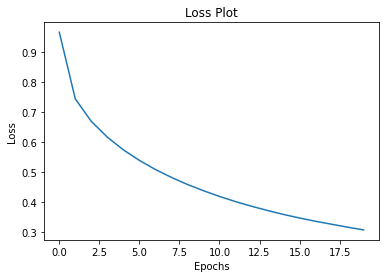

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_shape))

    hidden = decoder_network.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = cnn_model_feature(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder_network(img_tensor_val)

    decoder_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, aw = decoder_network(decoder_input, features, hidden)

        attention_plot[i] = tf.reshape(aw, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        decoder_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
def test_model(rid):
  rid = np.random.randint(0, len(val_images))
  image = val_images[rid]

  start = time.time()
  real_caption = ' '.join([tokenizer.index_word[i] for i in val_captions[rid] if i not in [0]])
  result, attention_plot = evaluate(image)


  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]

  for i in result:
      if i=="<unk>":
          result.remove(i)
        
  result_join = ' '.join(result)
  result_final = result_join.rsplit(' ', 1)[0]

  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = result_final
  score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
  print(f"BELU score: {score*100}")

  print ('Real Caption:', real_caption)
  print ('Prediction Caption:', result_final)
  plot_attention(image, result, attention_plot)

  Image.open(val_images[rid])

BELU score: 10.232890201933017
Real Caption: a white and black cat being friendly with a dog
Prediction Caption: a dog touching his face to a cats face to a cats face to a cats face to a cats face to a cats face to a cats face to a cats face to a cats face to a cats face to a cats face to a cats face to


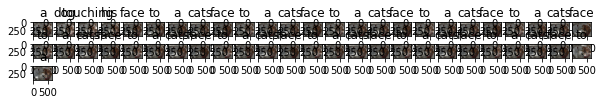

time took to Predict: 6 sec


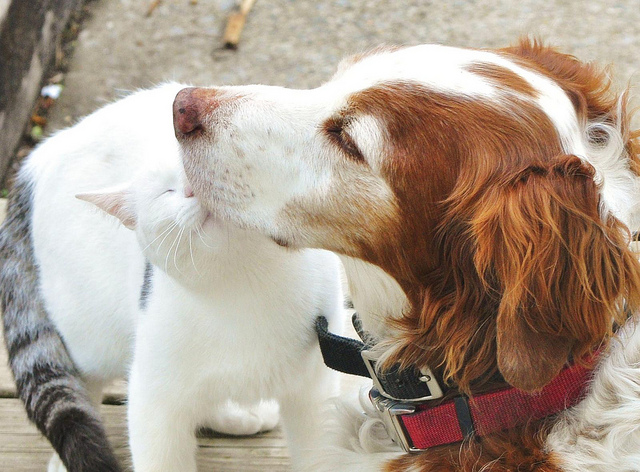

In [ ]:
rid = np.random.randint(0, len(val_images))
test_model(rid)

BELU score: 0
Real Caption: the old building is taller than most in the town
Prediction Caption: a large church tower with a clock tower with a large clock tower with a large clock tower with a large clock tower with a large clock tower with a large clock tower with a large clock tower with a large clock tower with a large clock tower with a


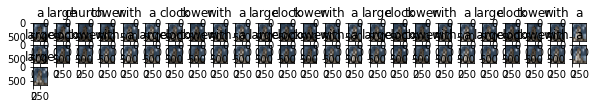

time took to Predict: 6 sec


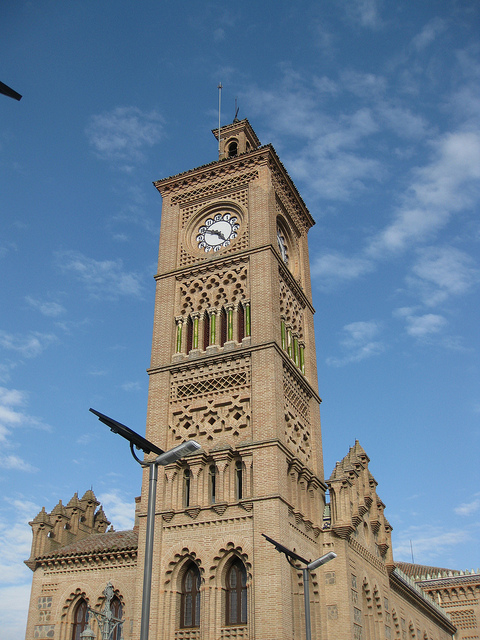

In [ ]:
rid = np.random.randint(0, len(val_images))
test_model(rid)

BELU score: 8.622612271184538
Real Caption: a fire hyrdrant under a big balloon
Prediction Caption: a red and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow and yellow


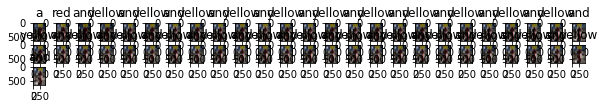

time took to Predict: 5 sec


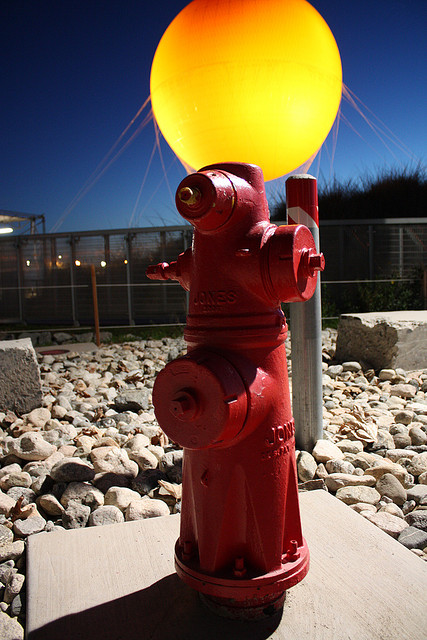

In [ ]:
rid = np.random.randint(0, len(val_images))
test_model(rid)

BELU score: 25.802943589457794
Real Caption: black and white photo of woman appearing to be pregnant on bench backed by wall
Prediction Caption: a woman sitting on a bench


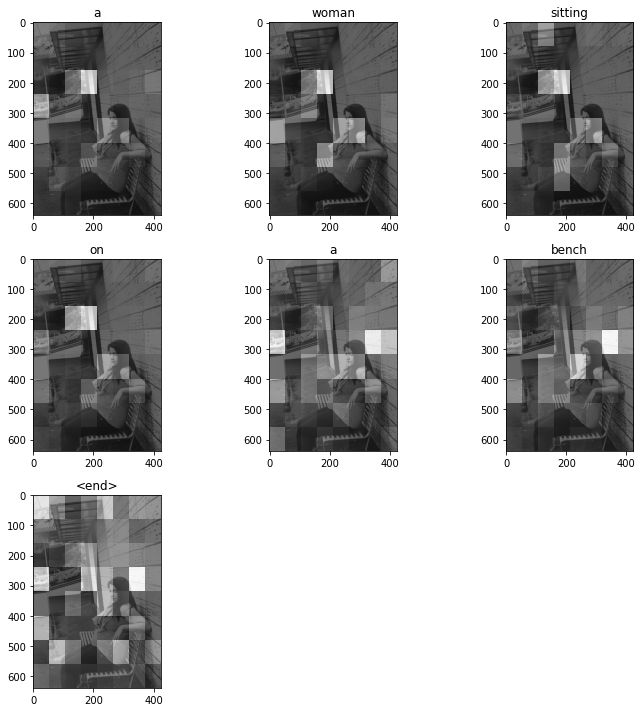

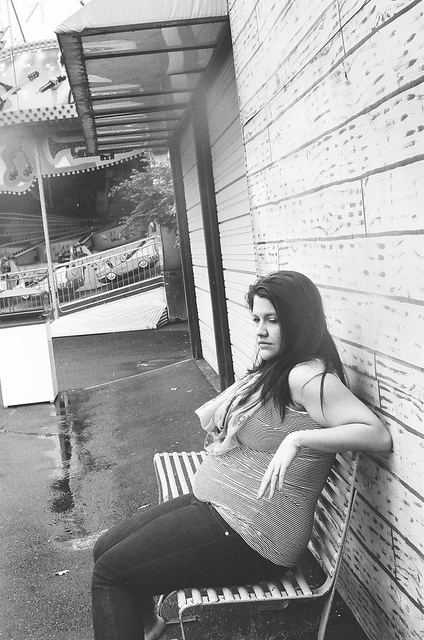

In [ ]:
rid = np.random.randint(0, len(val_images))
test_model(rid)